<a href="https://colab.research.google.com/github/ariG23498/SimCLR_PseudoLabel/blob/master/10_Per_Fine-tune_CIFAR10_Vanilla_SimCLR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# TensorFlow Imports
import tensorflow as tf
print(tf.__version__)

2.3.0


In [2]:
!nvidia-smi

Fri Aug 21 06:32:33 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8    29W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!wget https://raw.githubusercontent.com/GoogleCloudPlatform/keras-idiomatic-programmer/master/zoo/resnet/resnet_cifar10.py

In [ ]:
!wget https://storage.googleapis.com/resnet-simclr-pseudo-labels/vanilla_resnet_simclr_cifar10.h5

In [5]:
# Other imports
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import matplotlib.pyplot as plt
from imutils import paths
import tensorflow as tf
import seaborn as sns
import numpy as np
import resnet_cifar10
import cv2

# Random seed fixation
tf.random.set_seed(666)
np.random.seed(666)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [14]:
# Load the full set of CIFAR10
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Sample 10% for fine-tuning
train_indices = np.random.choice(len(x_train), 5000, replace=False)
x_train_frac = x_train[train_indices, :]
y_train_frac = y_train[train_indices, :]

# Prepare the dataset
x_train_frac = x_train_frac.astype("float32") / 255.
x_test = x_test.astype("float32") / 255.

In [7]:
# ResNetCIFAR10
n = 4
depth =  n * 9 + 2
n_blocks = ((depth - 2) // 9) - 1

# The input tensor
inputs = Input(shape=(32, 32, 3))

# The Stem Convolution Group
x = resnet_cifar10.stem(inputs)
   
# The learner
outputs = resnet_cifar10.learner(x, n_blocks)

# Instantiate the Model
resnet_headless_model = Model(inputs, outputs)

In [8]:
# Architecture utils
def get_resnet_simclr_deeper(hidden_1, hidden_2, hidden_3):
    inputs = Input((32, 32, 3))
    h = resnet_headless_model(inputs, training=False)
    h = GlobalAveragePooling2D()(h)
    
    projection_1 = Dense(hidden_1)(h)
    projection_1 = Activation("relu")(projection_1)
    projection_2 = Dense(hidden_2)(projection_1)
    projection_2 = Activation("relu")(projection_2)
    projection_3 = Dense(hidden_3)(projection_2)

    resnet_simclr = Model(inputs, projection_3)

    return resnet_simclr

In [9]:
resnet_simclr = get_resnet_simclr_deeper(256, 128, 50)
resnet_simclr.load_weights("vanilla_resnet_simclr_cifar10.h5")
resnet_simclr.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
functional_3 (Functional)    (None, 8, 8, 256)         1121344   
_________________________________________________________________
global_average_pooling2d (Gl (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
activation_1 (Activation)    (None, 128)              

In [10]:
def plot_training(H):
	with plt.xkcd():
		plt.plot(H.history["loss"], label="train_loss")
		plt.plot(H.history["val_loss"], label="val_loss")
		plt.plot(H.history["accuracy"], label="train_acc")
		plt.plot(H.history["val_accuracy"], label="val_acc")
		plt.title("Training Loss and Accuracy")
		plt.xlabel("Epoch #")
		plt.ylabel("Loss/Accuracy")
		plt.legend(loc="lower left")
		plt.show()

In [12]:
# Encoder model with no projection
extractor = Model(resnet_simclr.input, resnet_simclr.layers[-6].output) # weights are already loaded

def get_training_model(trainable=False):
    inputs = Input(shape=(32, 32, 3))
    extractor.trainable = trainable
    x = extractor(inputs, training=False)
    x = Dense(10, activation="softmax")(x)
    classifier = Model(inputs=inputs, outputs=x)
    
    return classifier

## Warmup

In [13]:
# Early Stopping to prevent overfitting
es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2, verbose=2, restore_best_weights=True)

Epoch 1/35
79/79 [==============================] - 8s 105ms/step - loss: 2.6494 - accuracy: 0.1686 - val_loss: 2.1054 - val_accuracy: 0.2436
Epoch 2/35
79/79 [==============================] - 7s 94ms/step - loss: 2.0439 - accuracy: 0.2734 - val_loss: 1.9775 - val_accuracy: 0.2796
Epoch 3/35
79/79 [==============================] - 7s 94ms/step - loss: 1.9357 - accuracy: 0.2980 - val_loss: 1.9233 - val_accuracy: 0.3059
Epoch 4/35
79/79 [==============================] - 7s 94ms/step - loss: 1.9054 - accuracy: 0.3038 - val_loss: 1.8803 - val_accuracy: 0.3153
Epoch 5/35
79/79 [==============================] - 7s 95ms/step - loss: 1.8685 - accuracy: 0.3240 - val_loss: 1.8531 - val_accuracy: 0.3260
Epoch 6/35
79/79 [==============================] - 8s 95ms/step - loss: 1.8490 - accuracy: 0.3334 - val_loss: 1.8483 - val_accuracy: 0.3264
Epoch 7/35
79/79 [==============================] - 7s 94ms/step - loss: 1.8372 - accuracy: 0.3340 - val_loss: 1.8281 - val_accuracy: 0.3406
Epoch 8/35
7

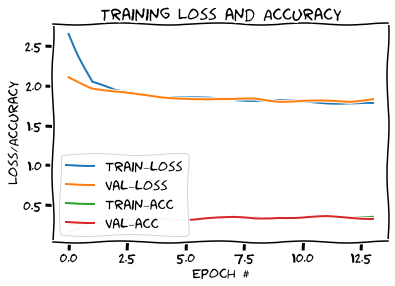

In [18]:
model = get_training_model()

model.compile(loss="sparse_categorical_crossentropy", metrics=["accuracy"],
                     optimizer='adam')

history = model.fit(x_train_frac, y_train_frac,
                 validation_data=(x_test, y_test),
                 batch_size=64,
                 epochs=35,
                 callbacks=[es])
plot_training(history)

## Fine-tune

In [19]:
model.layers[1].trainable = True
model.summary()

Model: "functional_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
functional_7 (Functional)    (None, 256)               1121344   
_________________________________________________________________
dense_6 (Dense)              (None, 10)                2570      
Total params: 1,123,914
Trainable params: 1,116,970
Non-trainable params: 6,944
_________________________________________________________________


Epoch 1/35
79/79 [==============================] - 15s 192ms/step - loss: 1.7575 - accuracy: 0.3700 - val_loss: 1.7759 - val_accuracy: 0.3655
Epoch 2/35
79/79 [==============================] - 14s 176ms/step - loss: 1.7360 - accuracy: 0.3778 - val_loss: 1.7639 - val_accuracy: 0.3659
Epoch 3/35
79/79 [==============================] - 14s 176ms/step - loss: 1.7203 - accuracy: 0.3834 - val_loss: 1.7578 - val_accuracy: 0.3670
Epoch 4/35
79/79 [==============================] - 14s 176ms/step - loss: 1.7062 - accuracy: 0.3894 - val_loss: 1.7501 - val_accuracy: 0.3684
Epoch 5/35
79/79 [==============================] - 14s 176ms/step - loss: 1.6926 - accuracy: 0.3958 - val_loss: 1.7461 - val_accuracy: 0.3714
Epoch 6/35
79/79 [==============================] - 14s 176ms/step - loss: 1.6803 - accuracy: 0.4012 - val_loss: 1.7342 - val_accuracy: 0.3765
Epoch 7/35
79/79 [==============================] - 14s 176ms/step - loss: 1.6683 - accuracy: 0.4078 - val_loss: 1.7274 - val_accuracy: 0.3801

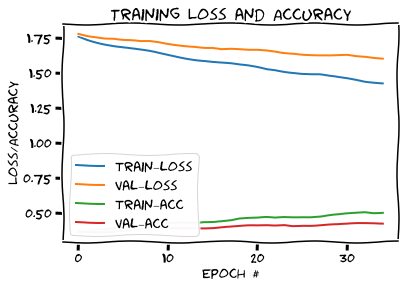

In [20]:
model.compile(loss="sparse_categorical_crossentropy", metrics=["accuracy"],
                     optimizer=tf.keras.optimizers.Adam(1e-5)) # Low learning rate

history = model.fit(x_train_frac, y_train_frac,
                 validation_data=(x_test, y_test),
                 batch_size=64,
                 epochs=35,
                 callbacks=[es])
plot_training(history)